# Arxpr dataset v3
this is subsets of the arxpr data, where the distribution of labels are as uniform as possible for the given dataset length.

raw data length: 14844
pmid-merged data length: 11017
data with single unique value in one of the fields: length: 10332
Cleaned dataset saved to '/mnt/data/upcast/data/arxpr3_holdout_not_normalized.json'
ignored pmids: 444 , len of cleaned data: 10251


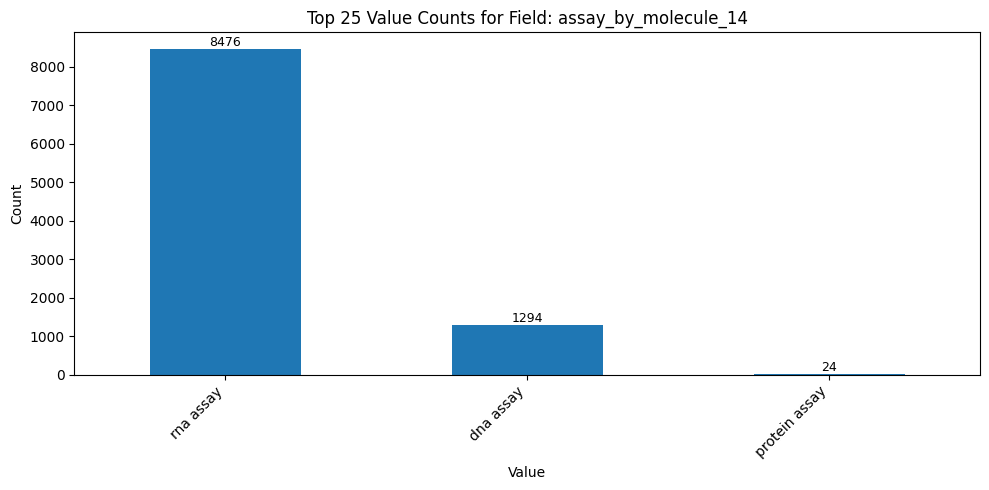

['rna assay', 'dna assay', 'protein assay']


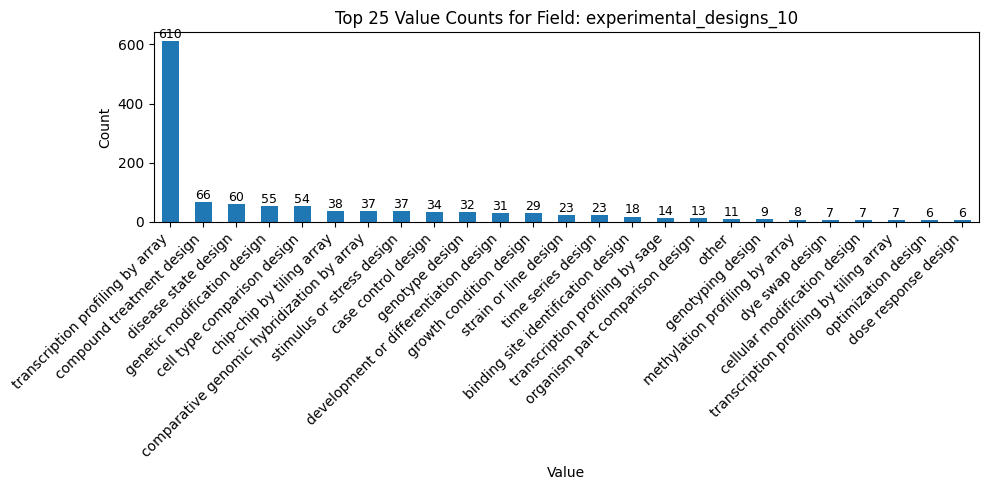

['transcription profiling by array', 'compound treatment design', 'disease state design', 'genetic modification design', 'cell type comparison design', 'chip-chip by tiling array', 'comparative genomic hybridization by array', 'stimulus or stress design', 'case control design', 'genotype design', 'development or differentiation design', 'growth condition design', 'strain or line design', 'time series design', 'binding site identification design', 'transcription profiling by sage', 'organism part comparison design', 'other', 'genotyping design', 'methylation profiling by array', 'dye swap design', 'cellular modification design', 'transcription profiling by tiling array', 'optimization design', 'dose response design']


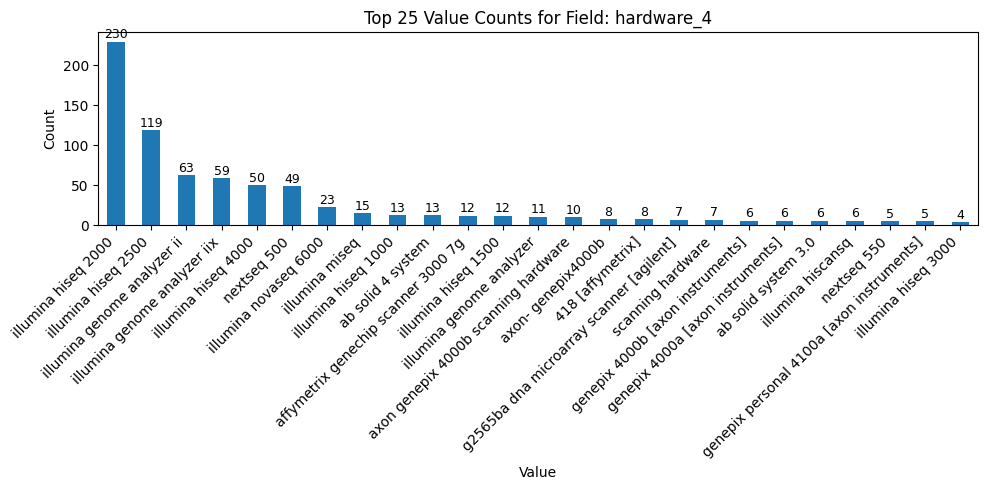

['illumina hiseq 2000', 'illumina hiseq 2500', 'illumina genome analyzer ii', 'illumina genome analyzer iix', 'illumina hiseq 4000', 'nextseq 500', 'illumina novaseq 6000', 'illumina miseq', 'illumina hiseq 1000', 'ab solid 4 system', 'affymetrix genechip scanner 3000 7g', 'illumina hiseq 1500', 'illumina genome analyzer', 'axon genepix 4000b scanning hardware', 'axon- genepix4000b', '418 [affymetrix]', 'g2565ba dna microarray scanner [agilent]', 'scanning hardware', 'genepix 4000b [axon instruments]', 'genepix 4000a [axon instruments]', 'ab solid system 3.0', 'illumina hiscansq', 'nextseq 550', 'genepix personal 4100a [axon instruments]', 'illumina hiseq 3000']


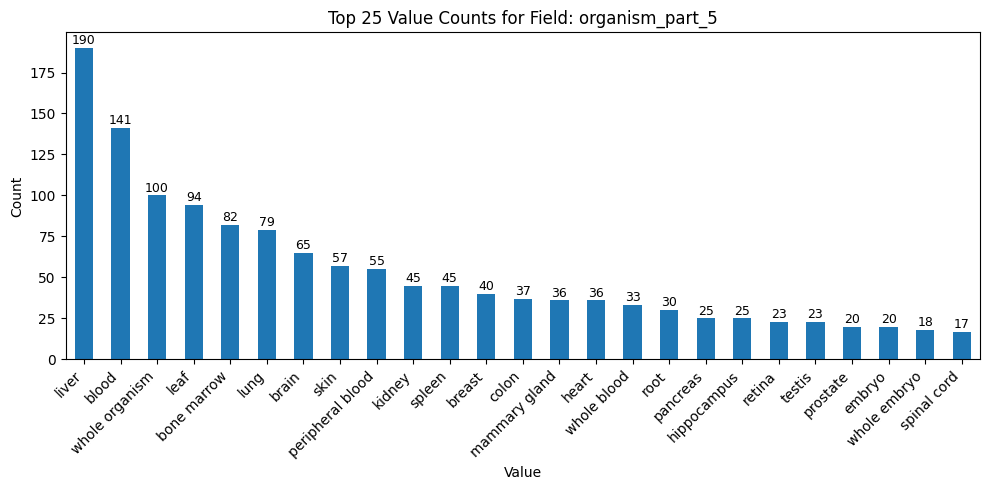

['liver', 'blood', 'whole organism', 'leaf', 'bone marrow', 'lung', 'brain', 'skin', 'peripheral blood', 'kidney', 'spleen', 'breast', 'colon', 'mammary gland', 'heart', 'whole blood', 'root', 'pancreas', 'hippocampus', 'retina', 'testis', 'prostate', 'embryo', 'whole embryo', 'spinal cord']


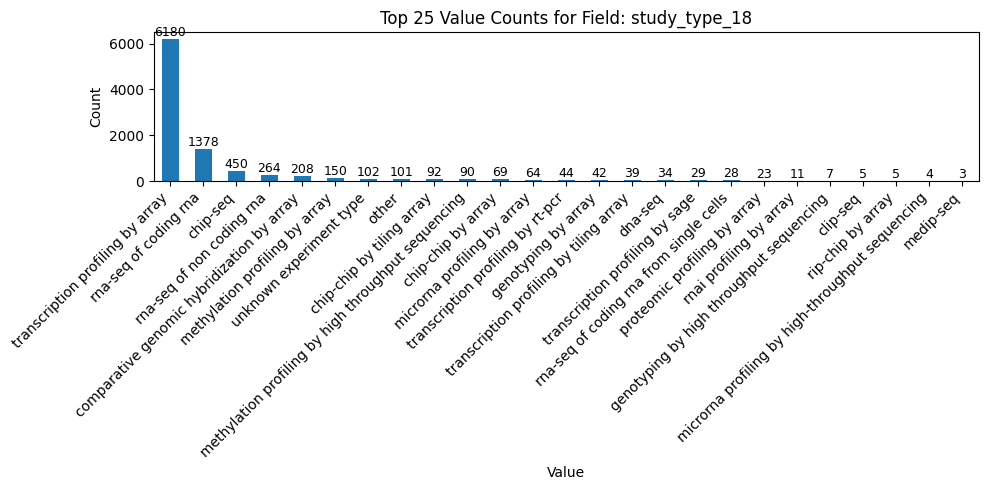

['transcription profiling by array', 'rna-seq of coding rna', 'chip-seq', 'rna-seq of non coding rna', 'comparative genomic hybridization by array', 'methylation profiling by array', 'unknown experiment type', 'other', 'chip-chip by tiling array', 'methylation profiling by high throughput sequencing', 'chip-chip by array', 'microrna profiling by array', 'transcription profiling by rt-pcr', 'genotyping by array', 'transcription profiling by tiling array', 'dna-seq', 'transcription profiling by sage', 'rna-seq of coding rna from single cells', 'proteomic profiling by array', 'rnai profiling by array', 'genotyping by high throughput sequencing', 'clip-seq', 'rip-chip by array', 'microrna profiling by high-throughput sequencing', 'medip-seq']


In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# -------- CONFIG --------
input_file = "/mnt/data/upcast/data/arxpr_simplified.json"
#output_file = "/mnt/data/upcast/data/arxpr3_holdout_not_normalized.json"
output_file = "/mnt/data/upcast/data/arxpr3_holdout_not_normalized.json"
ignored_keys = []



# -------- STEP 1: Load JSON --------
with open(input_file, 'r') as f:
    raw_data = json.load(f)
print("raw data length:", len(raw_data))

# -------- STEP 1.5: Merge data from same pmid --------
merged_data = {}
n_ignored_keys=0

for key, fields in raw_data.items():
    pmid = key.split("_")[0]
    if pmid in ignored_keys:
        n_ignored_keys += 1
        continue
    if pmid in merged_data:
        for field in fields:
            merged_data[pmid][field] = [*merged_data[pmid][field], *raw_data[key][field]]
    else:
        merged_data[pmid] = raw_data[key]

 

# -------- STEP 2: Clean & Normalize --------
intermediate_data = {}
value_counter = defaultdict(lambda: defaultdict(int))

print("pmid-merged data length:", len(merged_data))

for key, fields in merged_data.items():


    new_fields = {}
    all_empty = True

    for field, items in fields.items():
        if not field in ['hardware_4','organism_part_5','experimental_designs_10','assay_by_molecule_14','study_type_18']:
            continue
        values = [d["value"] for d in items if "value" in d]

        if not values:
            new_fields[field] = []
        elif all(v == values[0] for v in values):
            # All values the same → keep one
            new_fields[field] = [values[0]]
            value_counter[field][values[0]] += 1
            all_empty = False
        else:
            # Mixed values → discard
            new_fields[field] = []

    if not all_empty:
        intermediate_data[key] = new_fields

print("data with single unique value in one of the fields: length:", len(intermediate_data))


# -------- STEP 3: Identify Top 25 Values per Field --------
top_values_per_field = {}

for field, counter in value_counter.items():
    sorted_vals = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    top_values_per_field[field] = set([v for v, _ in sorted_vals[:25]])

# -------- STEP 4: Filter to Top 25 Values per Field --------
final_data = {}

for key, fields in intermediate_data.items():
    new_fields = {}
    for field, values in fields.items():
        if values and values[0] in top_values_per_field[field]:
            new_fields[field] = values
    if new_fields:
        final_data[key] = new_fields

# -------- STEP 5: Save Cleaned + Filtered Dataset --------
#with open(output_file, 'w') as f:
#    json.dump(final_data, f, indent=2)

print(f"Cleaned dataset saved to '{output_file}'")
print("ignored pmids:", n_ignored_keys, ", len of cleaned data:", len(final_data))


# -------- STEP 6: Plot per Field --------
# Recount values in final_data
field_value_counts = defaultdict(lambda: defaultdict(int))
fields = set()

for entry in final_data.values():
    for field, values in entry.items():
        val = values[0]
        field_value_counts[field][val] += 1
        fields.add(field)

for field in sorted(fields):
    counts = field_value_counts[field]
    df = pd.Series(counts).sort_values(ascending=False)

    plt.figure(figsize=(10, 5))
    ax = df.plot(kind='bar')
    plt.title(f'Top 25 Value Counts for Field: {field}')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')

    # Annotate bars
    for i, value in enumerate(df.values):
        ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()
    print(list(df.index.values))


In [25]:
import json
import random
from collections import defaultdict

def normalize_sample(input_file, output_file, max_per_field=300, seed=None):
    if seed is not None:
        random.seed(seed)

    # Load cleaned dataset
    with open(input_file, 'r') as f:
        data = json.load(f)

    items = list(data.items())
    random.shuffle(items)

    # field -> value -> list of (key, value)
    field_value_instances = defaultdict(lambda: defaultdict(list))

    for key, fields in items:
        for field, values in fields.items():
            if values:
                val = values[0]
                field_value_instances[field][val].append((key, val))

    # Track selected keys
    sampled_keys = defaultdict(set)

    for field, value_instances in field_value_instances.items():
        # Count available per value
        available_counts = {v: len(insts) for v, insts in value_instances.items()}
        total_available = sum(available_counts.values())
        target_total = min(max_per_field, total_available)
        if target_total < max_per_field:
            print(f"Field '{field}' only had {target_total} entries available (requested {max_per_field})")

        selected_counts = defaultdict(int)
        remaining_budget = target_total

        # Step 1: Fill each value up to a baseline evenly
        value_list = list(available_counts.keys())
        random.shuffle(value_list)
        while remaining_budget > 0:
            made_progress = False
            for v in value_list:
                if selected_counts[v] < available_counts[v] and remaining_budget > 0:
                    selected_counts[v] += 1
                    remaining_budget -= 1
                    made_progress = True
            if not made_progress:
                break  # Can't allocate further

        # Step 2: Sample exact number of items
        for val, count in selected_counts.items():
            instances = value_instances[val]
            random.shuffle(instances)
            for key, _ in instances[:count]:
                sampled_keys[key].add(field)

    # Step 3: Build final dataset
    final_data = {}
    for key, fields in data.items():
        if key not in sampled_keys:
            continue
        new_fields = {f: fields[f] for f in sampled_keys[key] if f in fields}
        if new_fields:
            for field in ['hardware_4','organism_part_5','experimental_designs_10','assay_by_molecule_14','study_type_18']:
                new_fields.setdefault(field, [])

            final_data[key] = new_fields

    # Save the result
    with open(output_file, 'w') as f:
        json.dump(final_data, f, indent=2)

    print(f"Dataset saved to '{output_file}' with exactly {max_per_field} per field (when possible).")


In [26]:
normalize_sample(
    input_file=output_file, # output from earlier
    output_file= "/mnt/data/upcast/data/arxpr3_25_150_metadataset_holdout.json",
    max_per_field=150,
    seed=43

)
normalize_sample(
    input_file=output_file, # output from earlier
    output_file= "/mnt/data/upcast/data/arxpr3_25_300_metadataset_holdout.json",
    max_per_field=300,
    seed=43
)
normalize_sample(
    input_file=output_file, # output from earlier
    output_file= "/mnt/data/upcast/data/arxpr3_25_10_metadataset_holdout.json",
    max_per_field=10,
    seed=43

)

Dataset saved to '/mnt/data/upcast/data/arxpr3_25_150_metadataset_holdout.json' with exactly 150 per field (when possible).
Dataset saved to '/mnt/data/upcast/data/arxpr3_25_300_metadataset_holdout.json' with exactly 300 per field (when possible).
Dataset saved to '/mnt/data/upcast/data/arxpr3_25_10_metadataset_holdout.json' with exactly 10 per field (when possible).


# Verify count (visualise)

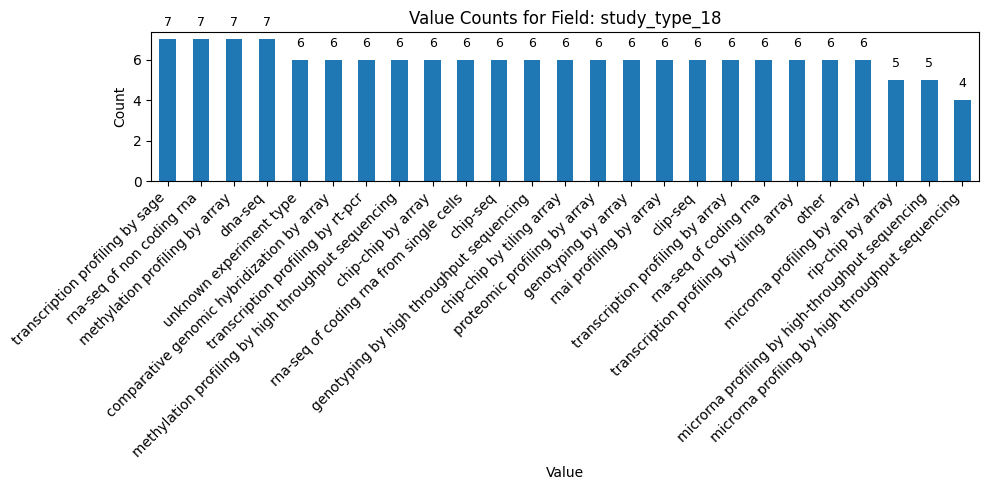

length 25
sum: 150


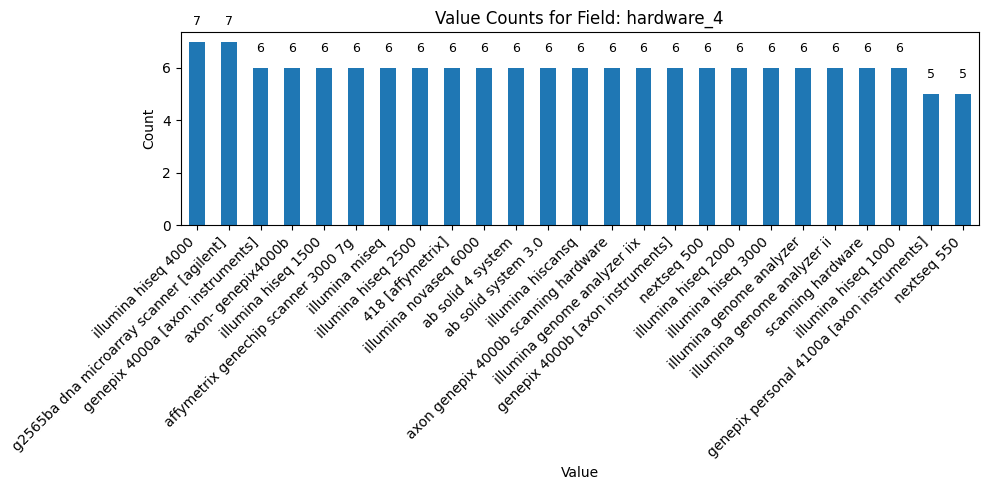

length 25
sum: 150


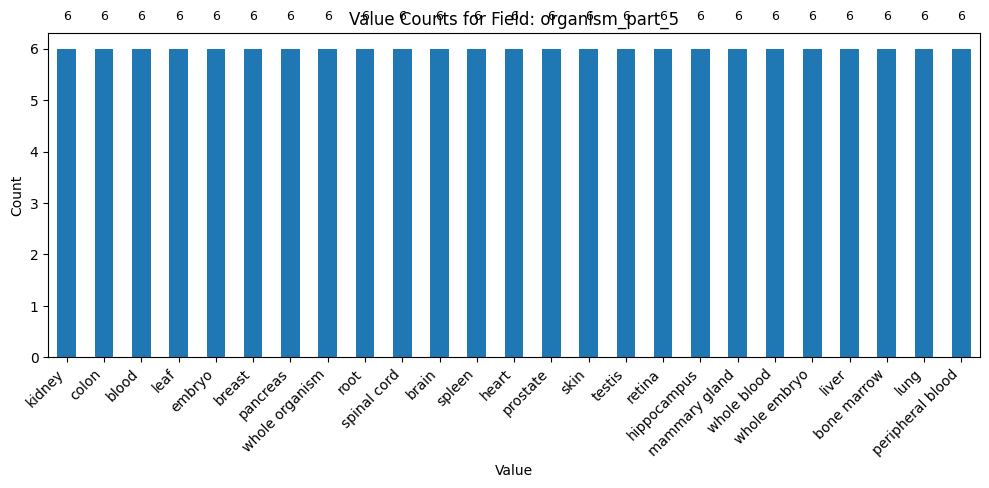

length 25
sum: 150


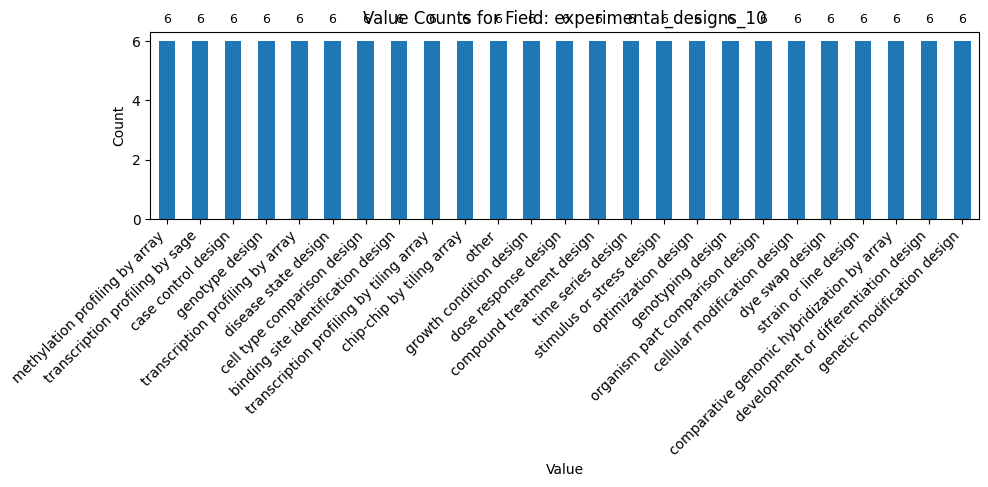

length 25
sum: 150


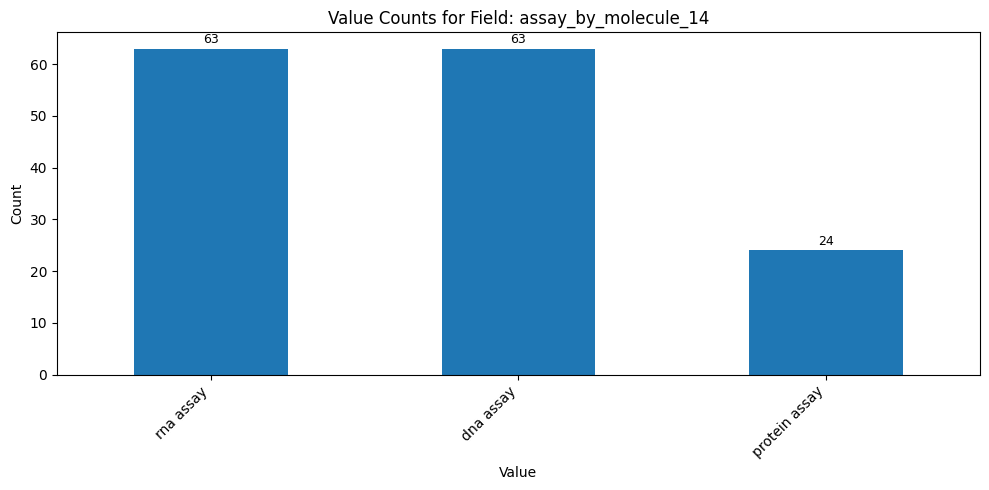

length 3
sum: 150


In [27]:

import json
import pandas as pd
import matplotlib.pyplot as plt

# Load the JSON data
with open("/mnt/data/upcast/data/arxpr3_25_150_metadataset_holdout.json", 'r') as f:
    data = json.load(f)

# Detect fields from any one entry
sample_key = next(iter(data))
fields = data[sample_key].keys()

# Collect counts for each field
field_value_counts = {field: {} for field in fields}

for entry in data.values():
    for field in fields:
        values = entry[field]
        if values:  # non-empty list
            val = values[0]
            field_value_counts[field][val] = field_value_counts[field].get(val, 0) + 1

# Plot with annotations
for field, counts in field_value_counts.items():
    if counts:
        df = pd.Series(counts).sort_values(ascending=False)

        plt.figure(figsize=(10, 5))
        ax = df.plot(kind='bar')
        plt.title(f'Value Counts for Field: {field}')
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')

        # Add annotations on bars
        for i, value in enumerate(df.values):
            ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()

        print("length", len(df.values))
        print("sum:", df.sum())

    #break # only hardware



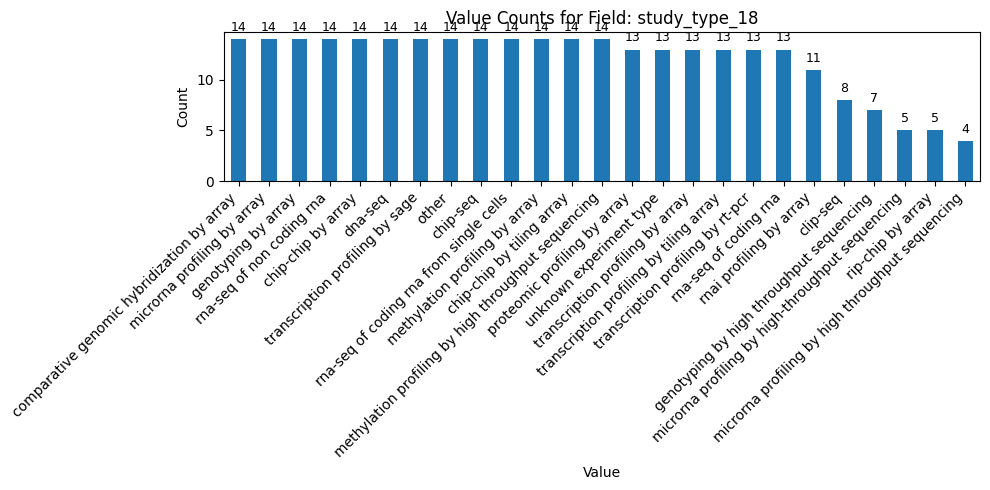

length 25
sum: 300


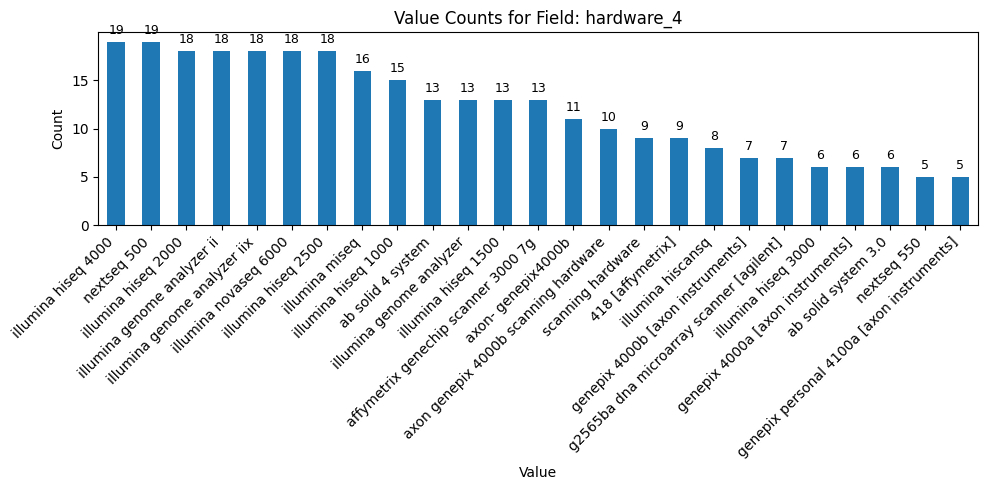

length 25
sum: 300


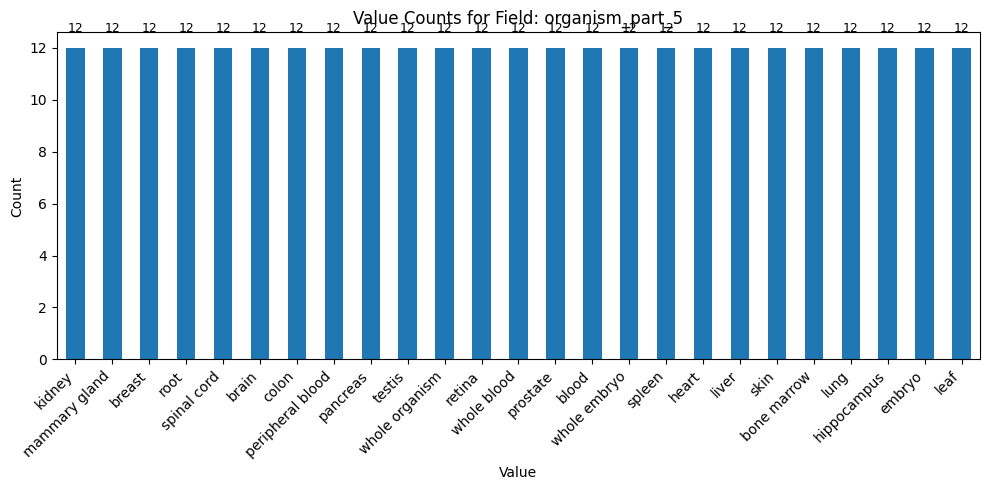

length 25
sum: 300


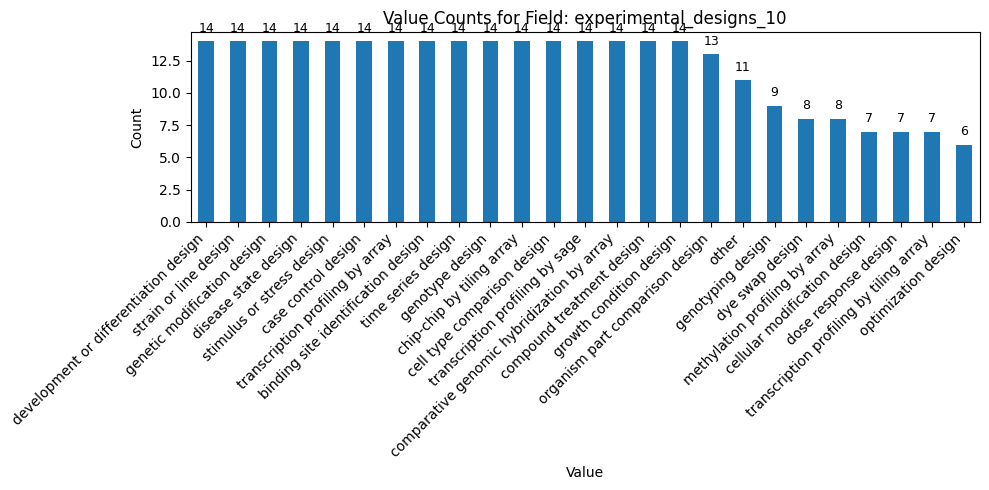

length 25
sum: 300


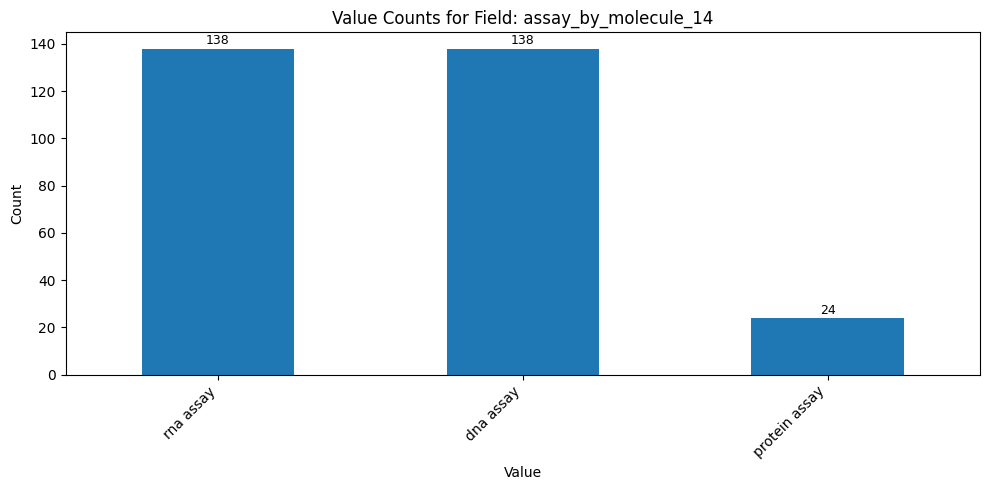

length 3
sum: 300


In [28]:

import json
import pandas as pd
import matplotlib.pyplot as plt

# Load the JSON data
with open("/mnt/data/upcast/data/arxpr3_25_300_metadataset_holdout.json", 'r') as f:
    data = json.load(f)

# Detect fields from any one entry
sample_key = next(iter(data))
fields = data[sample_key].keys()

# Collect counts for each field
field_value_counts = {field: {} for field in fields}

for entry in data.values():
    for field in fields:
        values = entry[field]
        if values:  # non-empty list
            val = values[0]
            field_value_counts[field][val] = field_value_counts[field].get(val, 0) + 1

# Plot with annotations
for field, counts in field_value_counts.items():
    if counts:
        df = pd.Series(counts).sort_values(ascending=False)

        plt.figure(figsize=(10, 5))
        ax = df.plot(kind='bar')
        plt.title(f'Value Counts for Field: {field}')
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')

        # Add annotations on bars
        for i, value in enumerate(df.values):
            ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()
        
        print("length", len(df.values))
        print("sum:", df.sum())



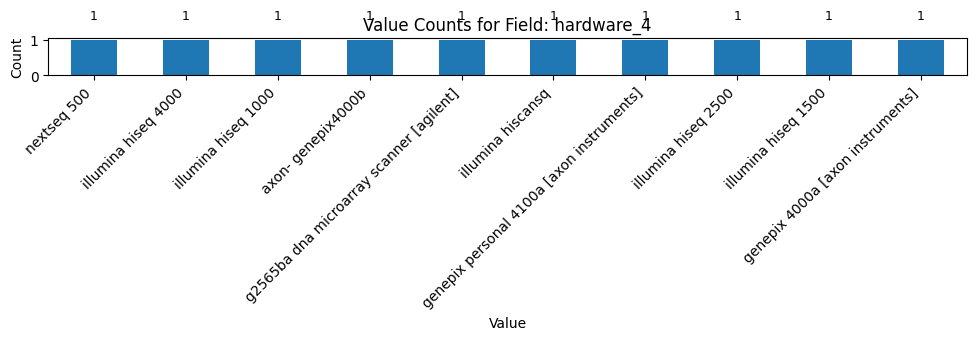

length 10
sum: 10


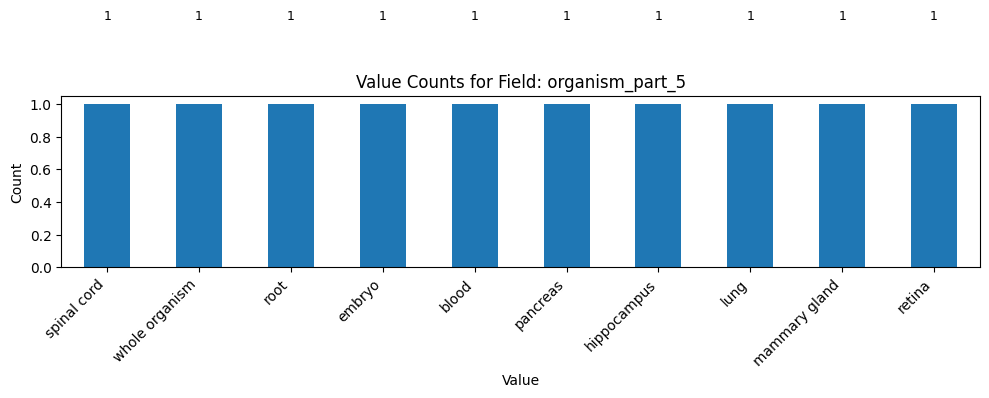

length 10
sum: 10


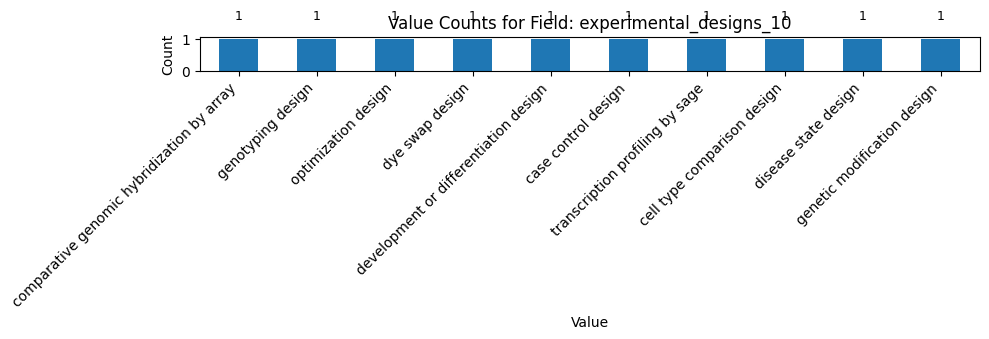

length 10
sum: 10


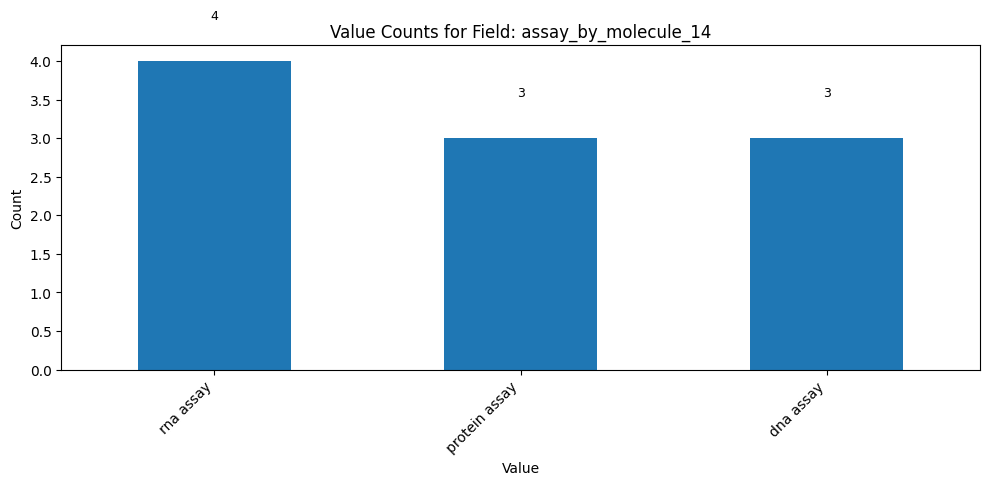

length 3
sum: 10


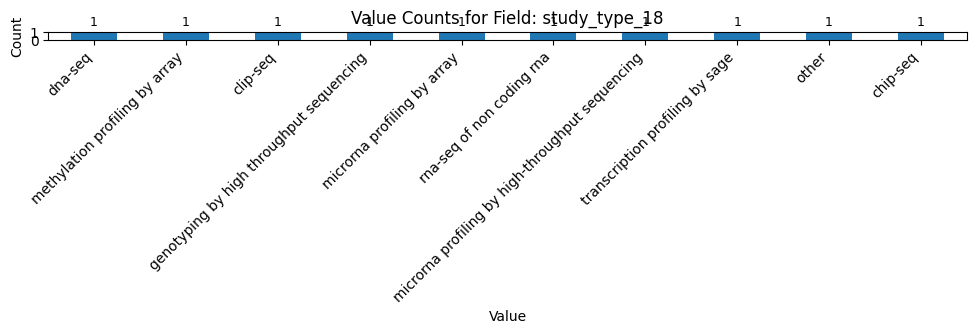

length 10
sum: 10


In [29]:

import json
import pandas as pd
import matplotlib.pyplot as plt

# Load the JSON data
with open("/mnt/data/upcast/data/arxpr3_25_10_metadataset_holdout.json", 'r') as f:
    data = json.load(f)

# Detect fields from any one entry
sample_key = next(iter(data))
fields = data[sample_key].keys()

# Collect counts for each field
field_value_counts = {field: {} for field in fields}

for entry in data.values():
    for field in fields:
        values = entry[field]
        if values:  # non-empty list
            val = values[0]
            field_value_counts[field][val] = field_value_counts[field].get(val, 0) + 1

# Plot with annotations
for field, counts in field_value_counts.items():
    if counts:
        df = pd.Series(counts).sort_values(ascending=False)

        plt.figure(figsize=(10, 5))
        ax = df.plot(kind='bar')
        plt.title(f'Value Counts for Field: {field}')
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')

        # Add annotations on bars
        for i, value in enumerate(df.values):
            ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.show()
        
        print("length", len(df.values))
        print("sum:", df.sum())

